# Challenge-2 Graph Theory
IMT Atlantique 

*Authors:*

1. *Antoine HORRER*

2. *Kadriye Nur BAKIRCI*

In [1]:
# Import necessary libraries
%matplotlib inline
import networkx as nx
from datetime import datetime
import random
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import itertools
!pip install EoN
import EoN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.2/113.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for EoN: filename=EoN-1.1-py3-none-any.whl size=120793 sha256=2e5c69ecf7f82014b534d34695aa2ca6dd3812aa545a3484838f038f41095a48
  Stored in directory: /root/.cache/pip/wheels/cc/38/06/01956d0db50e69cbcd6752d4b362685690c4fc17a80674bf18
Successfully built EoN


In [2]:
# Connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create graphs from csv with affiliation, via edgelists
Affiliation: nodes belong to a group_id, eg. household, school, company

Objective: Create cliques in households, or pseudo cliques in school/company according to the given degree of nodes

In [41]:
# Read csv file and save them as dataframe
df_h = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Graph Theory/Challenge 2/households.csv')
df_a = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Graph Theory/Challenge 2/pro_contacts_adults.csv')
df_c = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Graph Theory/Challenge 2/pro_contacts_children.csv')

In [4]:
# Check household csv file
df_h.head()

,Unnamed: 0,nb_children,nb_adults,type,size
0,0,2,2,two_parent_family,4
1,1,1,2,two_parent_family,3
2,2,0,3,two_parent_family,3
3,3,2,2,two_parent_family,4
4,4,2,2,two_parent_family,4


In [42]:
# Change the first column's name
df_h.rename(columns = {"Unnamed: 0" : "household_id"}, inplace = True)

In [7]:
# Check adults csv file
df_a.head()

,household_id,adult_id,job_cat,pro_contacts,company_id
0,0,0,Indus_other,52,6.0
1,0,1,Hotel_Restaurant,114,21.0
2,1,2,Shops_other,14,45.0
3,1,3,Administration_schools,33,10.0
4,2,4,Services_other,770,34.0


In [8]:
# Check children csv file
df_c.head()

,household_id,child_id,school_contacts,school_id
0,0,6960,35,2
1,0,6961,58,6
2,1,6962,92,5
3,3,6963,25,9
4,3,6964,85,1


In [45]:
dataframes = [df_h, df_a, df_c]
for df in dataframes:
  # Get the shape of the dataframe
  print(f'Dataset shape:\n{df.shape}\n')

  # Get the names of the attributes
  print(f'Dataset attributes:\n{df.columns}\n')

  # Get the overall description of the dataset with the data types
  print(f'Dataset general information:\n{df.info()}\n')

  # Get description of categorical attributes
  print(f'Dataset description:\nCategorical Data\n{df.describe()}')

Dataset shape:
(3802, 5)

Dataset attributes:
Index(['household_id', 'nb_children', 'nb_adults', 'type', 'size'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3802 entries, 0 to 3801
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   household_id  3802 non-null   int64 
 1   nb_children   3802 non-null   int64 
 2   nb_adults     3802 non-null   int64 
 3   type          3802 non-null   object
 4   size          3802 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 148.6+ KB
Dataset general information:
None

Dataset description:
Categorical Data
       household_id  nb_children    nb_adults         size
count    3802.00000  3802.000000  3802.000000  3802.000000
mean     1900.50000     0.811415     1.830615     2.642031
std      1097.68719     1.054897     1.021335     1.499259
min         0.00000     0.000000     1.000000     1.000000
25%       950.25000     0.000000     1.000000    

In [9]:
# Choose only household_id and adult_id columns and change adult_id column name to node_id
df_a = df_a[['household_id','adult_id']]
df_a.rename(columns={'adult_id':'node_id'}, inplace=True)
# Do same for children's csv file
df_c = df_c[['household_id','child_id']]
df_c.rename(columns={'child_id':'node_id'}, inplace=True)

<ipython-input-9-ee9a54aa8923>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a.rename(columns={'adult_id':'node_id'}, inplace=True)
<ipython-input-9-ee9a54aa8923>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c.rename(columns={'child_id':'node_id'}, inplace=True)


In [10]:
# concatenation top/bottom
df=pd.concat([df_a,df_c], axis=0)
# After concatenation, my index is screwed up: it counts up to n 
# (where n is the shape[0] of the corresponding dataframe), and restarts at zero at the next dataframe.
df=df.reset_index(drop=True)
print("len(df_a): %d, len(df_c): %d, len(df): %d" %(len(df_a),len(df_c),len(df)))

len(df_a): 6960, len(df_c): 3085, len(df): 10045


Now we can easily get the nodes in each household, and build edgelists such as nodes in the same household form a clique




In [11]:
gb=df.groupby('household_id')
gb.groups
# a dict with with households as keys, and lists of nodes index as values
# Each value is a sequence of the index locations for the rows belonging to that particular group

{0: [0, 1, 6960, 6961], 1: [2, 3, 6962], 2: [4, 5, 6], 3: [7, 8, 6963, 6964], 4: [9, 10, 6965, 6966], 5: [11, 12, 13], 6: [14, 15, 16], 7: [17, 18, 6967], 8: [19, 20, 6968], 9: [21, 22, 6969, 6970], 10: [23, 24, 6971, 6972, 6973, 6974], 11: [25, 26, 6975, 6976, 6977, 6978], 12: [27, 28, 29], 13: [30, 31, 6979, 6980], 14: [32, 33, 6981, 6982], 15: [34, 35, 36, 6983, 6984, 6985], 16: [37, 38, 39], 17: [40, 41, 6986], 18: [42, 43, 6987], 19: [44, 45, 6988], 20: [46, 47, 6989, 6990, 6991], 21: [48, 49, 50, 51], 22: [52, 53, 6992, 6993, 6994, 6995], 23: [54, 55, 6996, 6997, 6998], 24: [56, 57, 58], 25: [59, 60, 61], 26: [62, 63, 6999, 7000], 27: [64, 65, 66, 7001, 7002, 7003], 28: [67, 68, 7004], 29: [69, 70, 7005, 7006], 30: [71, 72, 73, 7007], 31: [74, 75, 76, 7008, 7009], 32: [77, 78, 79], 33: [80, 81, 7010, 7011, 7012], 34: [82, 83, 84, 85, 86], 35: [87, 88, 89, 7013], 36: [90, 91, 7014], 37: [92, 93, 7015], 38: [94, 95, 7016, 7017], 39: [96, 97, 98], 40: [99, 100, 101], 41: [102, 103, 

In [12]:
# Get the value for index 6960
df['node_id'].iloc[6960]

6960

In [13]:
# Check value for household_id = 18
df[df.household_id==18]

,household_id,node_id
42,18,42
43,18,43
6987,18,6987


In [14]:
# Create edgelists within groups. Undirected edges
# k-combinations of an n-element set, k=2
items = ['a', 'b', 'c']
for c in combinations(items, 2):
    print(c)

('a', 'b')
('a', 'c')
('b', 'c')


In [15]:
# Create edgelist
edgelist=[]
for name,group in gb.groups.items():
    for (index1,index2) in combinations(group, 2):
        edgelist.append((df['node_id'].iloc[index1],df['node_id'].iloc[index2]))
edgelist

[(0, 1),
 (0, 6960),
 (0, 6961),
 (1, 6960),
 (1, 6961),
 (6960, 6961),
 (2, 3),
 (2, 6962),
 (3, 6962),
 (4, 5),
 (4, 6),
 (5, 6),
 (7, 8),
 (7, 6963),
 (7, 6964),
 (8, 6963),
 (8, 6964),
 (6963, 6964),
 (9, 10),
 (9, 6965),
 (9, 6966),
 (10, 6965),
 (10, 6966),
 (6965, 6966),
 (11, 12),
 (11, 13),
 (12, 13),
 (14, 15),
 (14, 16),
 (15, 16),
 (17, 18),
 (17, 6967),
 (18, 6967),
 (19, 20),
 (19, 6968),
 (20, 6968),
 (21, 22),
 (21, 6969),
 (21, 6970),
 (22, 6969),
 (22, 6970),
 (6969, 6970),
 (23, 24),
 (23, 6971),
 (23, 6972),
 (23, 6973),
 (23, 6974),
 (24, 6971),
 (24, 6972),
 (24, 6973),
 (24, 6974),
 (6971, 6972),
 (6971, 6973),
 (6971, 6974),
 (6972, 6973),
 (6972, 6974),
 (6973, 6974),
 (25, 26),
 (25, 6975),
 (25, 6976),
 (25, 6977),
 (25, 6978),
 (26, 6975),
 (26, 6976),
 (26, 6977),
 (26, 6978),
 (6975, 6976),
 (6975, 6977),
 (6975, 6978),
 (6976, 6977),
 (6976, 6978),
 (6977, 6978),
 (27, 28),
 (27, 29),
 (28, 29),
 (30, 31),
 (30, 6979),
 (30, 6980),
 (31, 6979),
 (31, 6980

In [16]:
# Show the number of edges
len(edgelist)

12519

Now we can load a networkX graph, and/or save the list in csv file...

[NetworkX](https://networkx.github.io/documentation/stable/reference/classes/graph.html)

In [17]:
# Create Graph
G = nx.Graph()
G.add_edges_from(edgelist)
G.number_of_edges()

12519

In [18]:
# Show the information of graph G
print(G)

Graph with 8980 nodes and 12519 edges


The code sets a threshold value for the minimum number of nodes in a cluster. It then finds the connected components in the graph G using the connected_components() function from the nx module. It filters out the clusters that exceed the threshold by creating a list comprehension. The number of clusters exceeding the threshold is calculated by taking the length of the filtered list.

In [19]:
# Set the threshold for the minimum number of nodes in a cluster
threshold = 3

# Find connected components in the graph
connected_components = list(nx.connected_components(G))

# Filter clusters exceeding the threshold
clusters_exceeding_threshold = [cluster for cluster in connected_components if len(cluster) > threshold]

# Count the number of clusters exceeding the threshold
num_clusters_exceeding_threshold = len(clusters_exceeding_threshold)

# Print the results
print("Number of clusters exceeding the threshold:", num_clusters_exceeding_threshold)

Number of clusters exceeding the threshold: 913


In [20]:
# Number of simulations
num_simulations = 10

# List to store the results
results = []

# Run the epidemic model for multiple simulations
for sim in range(num_simulations):
    # Initialize the infection status for all nodes
    infection_status = {node: False for node in G.nodes()}

    # Select a randomly 10 clusters that exceed the threshold
    eligible_clusters = [cluster for cluster in clusters_exceeding_threshold if len(cluster) > threshold]
    selected_clusters = random.sample(eligible_clusters, 913)

    # Select a randomly node from each selected cluster as the initial infected node
    initial_infected_nodes = []
    for cluster in selected_clusters:
        initial_infected_node = random.choice(list(cluster))
        initial_infected_nodes.append(initial_infected_node)

    # Run the epidemic model using the EoN library
    t, S, I, R = EoN.fast_SIR(G, tau=0.05, gamma=0.02, initial_infecteds=initial_infected_nodes, tmax=100)

    # Measure the loss in terms of deaths, infectious rate, and recovery rate
    num_deaths = R[-1] 
    infectious_rate = sum(I) / (len(G.nodes()) * len(t) )
    recovery_rate = sum(R) / (len(G.nodes()) * len(t)  )

    # Store the results in a dictionary
    result = {
        'Simulation': sim + 1,
        'Deaths': num_deaths,
        'Infectious Rate': infectious_rate,
        'Recovery Rate': recovery_rate
    }
    results.append(result)

# Create a dataframe from the results
df_results = pd.DataFrame(results)

# Display the results
print(df_results)

   Simulation  Deaths  Infectious Rate  Recovery Rate
0           1    3322         0.217078       0.118438
1           2    3314         0.218335       0.117976
2           3    3358         0.218741       0.119360
3           4    3302         0.214546       0.118145
4           5    3341         0.217648       0.119127
5           6    3316         0.219921       0.118018
6           7    3302         0.221598       0.116873
7           8    3266         0.213643       0.117483
8           9    3282         0.222730       0.115556
9          10    3353         0.219293       0.119557


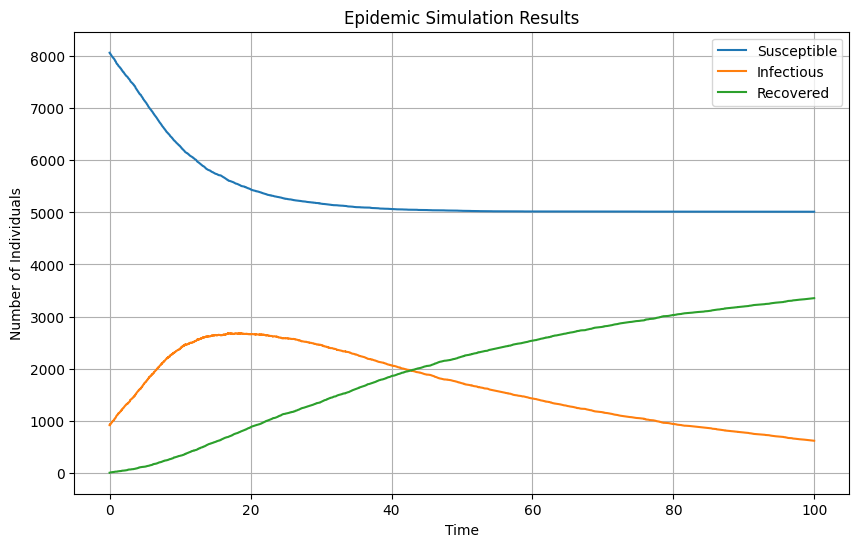

In [21]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t,S, label= "Susceptible")
plt.plot(t, I, label='Infectious')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.title('Epidemic Simulation Results')
plt.legend()
plt.grid(True)
plt.show()

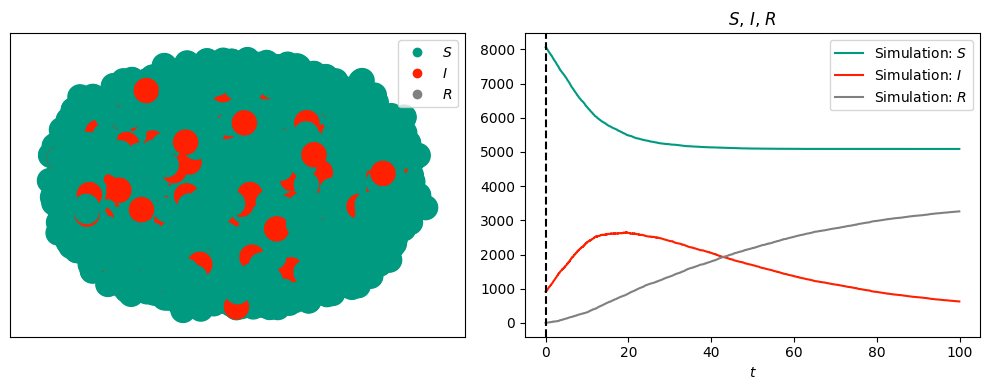

In [22]:
sim = EoN.fast_SIR(G, tau=0.05, gamma=0.02, initial_infecteds=initial_infected_nodes, tmax=100,return_full_data=True)
ani=sim.animate(ts_plots=["SIR"])
ani.save("SIR_ba-g1-b10-N1.mp4", fps=5,\
extra_args=["-vcodec", "libx264"])

In [23]:
# Set the threshold for the minimum number of nodes in a cluster
threshold = 3

# Find connected components in the graph
connected_components = list(nx.connected_components(G))

# Filter clusters exceeding the threshold
clusters_exceeding_threshold = [cluster for cluster in connected_components if len(cluster) > threshold]

# Calculate the number of clusters exceeding the threshold
num_clusters_exceeding_threshold = len(clusters_exceeding_threshold)

# Iterate over the clusters exceeding the threshold
for cluster in clusters_exceeding_threshold:
    # Create a subgraph for the current cluster
    subgraph = G.subgraph(cluster)
    
    # Calculate the betweenness centrality of each edge in the subgraph
    edge_betweenness = nx.edge_betweenness_centrality(subgraph)
    
    # Sort the edges based on betweenness centrality in descending order
    sorted_edges = sorted(edge_betweenness, key=edge_betweenness.get, reverse=True)
    
    # Iterate over the sorted edges
    for edge in sorted_edges:
        # Remove the edge from the graph
        G.remove_edge(*edge)
        
        # Check if the removal of the edge has resulted in breaking the cluster
        if not nx.is_connected(G.subgraph(cluster)):
            # If the cluster is now disconnected, stop removing edges
            break

# Find connected components in the modified graph
new_connected_components = list(nx.connected_components(G))

# Filter clusters exceeding the threshold in the modified graph
new_clusters_exceeding_threshold = [cluster for cluster in new_connected_components if len(cluster) > threshold]

# Calculate the number of clusters exceeding the threshold after edge removal
num_clusters_exceeding_threshold_after_removal = len(new_clusters_exceeding_threshold)

# Print the results
print("Number of clusters exceeding the threshold before edge removal:", num_clusters_exceeding_threshold)
print("Number of clusters exceeding the threshold after edge removal:", num_clusters_exceeding_threshold_after_removal)

Number of clusters exceeding the threshold before edge removal: 913
Number of clusters exceeding the threshold after edge removal: 379


In [24]:
# Number of simulations
num_simulations = 10

# List to store the results
results = []

# Run the epidemic model for multiple simulations
for sim in range(num_simulations):
    # Initialize the infection status for all nodes
    infection_status = {node: False for node in G.nodes()}

    # Select a randomly 10 clusters that exceed the threshold
    eligible_clusters = [cluster for cluster in new_clusters_exceeding_threshold if len(cluster) > threshold]
    selected_clusters = random.sample(eligible_clusters, 379)

    # Select a randomly node from each selected cluster as the initial infected node
    initial_infected_nodes = []
    for cluster in selected_clusters:
        initial_infected_node = random.choice(list(cluster))
        initial_infected_nodes.append(initial_infected_node)

    # Run the epidemic model using the EoN library
    t, S, I, R = EoN.fast_SIR(G, tau=0.05, gamma=0.02, initial_infecteds=initial_infected_nodes, tmax=100)

    # Measure the loss in terms of deaths, infectious rate, and recovery rate
    num_deaths = R[-1] 
    infectious_rate = sum(I) / (len(G.nodes()) * len(t))
    recovery_rate = sum(R) / (len(G.nodes()) * len(t))

    # Store the results in a dictionary
    result = {
        'Simulation': sim + 1,
        'Deaths': num_deaths,
        'Infectious Rate': infectious_rate,
        'Recovery Rate': recovery_rate
    }
    results.append(result)

# Create a dataframe from the results
df_results = pd.DataFrame(results)

# Display the results
print(df_results)

   Simulation  Deaths  Infectious Rate  Recovery Rate
0           1    1362         0.090428       0.048801
1           2    1360         0.090309       0.048610
2           3    1336         0.092461       0.047367
3           4    1379         0.094204       0.047942
4           5    1430         0.092206       0.050612
5           6    1362         0.089816       0.048912
6           7    1389         0.091030       0.049585
7           8    1376         0.092535       0.048582
8           9    1404         0.091722       0.049991
9          10    1375         0.093994       0.047908


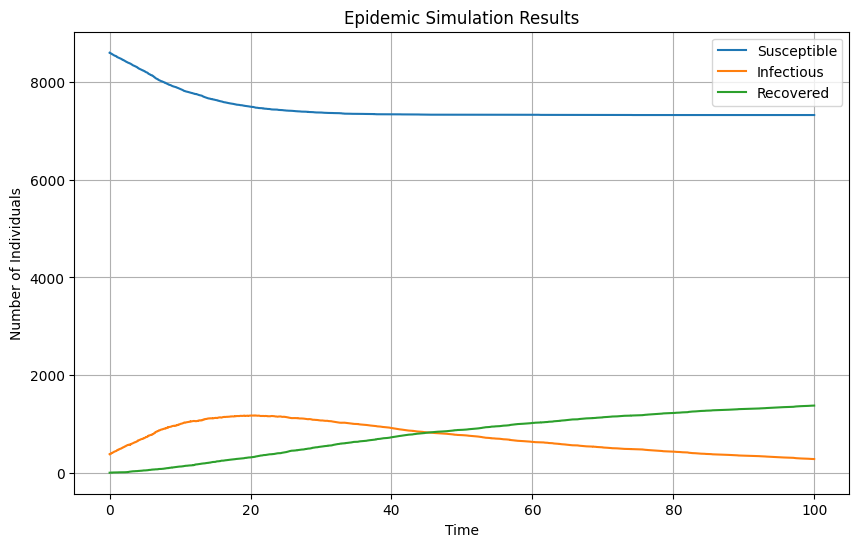

In [25]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t,S, label= "Susceptible")
plt.plot(t, I, label='Infectious')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.title('Epidemic Simulation Results')
plt.legend()
plt.grid(True)
plt.show()

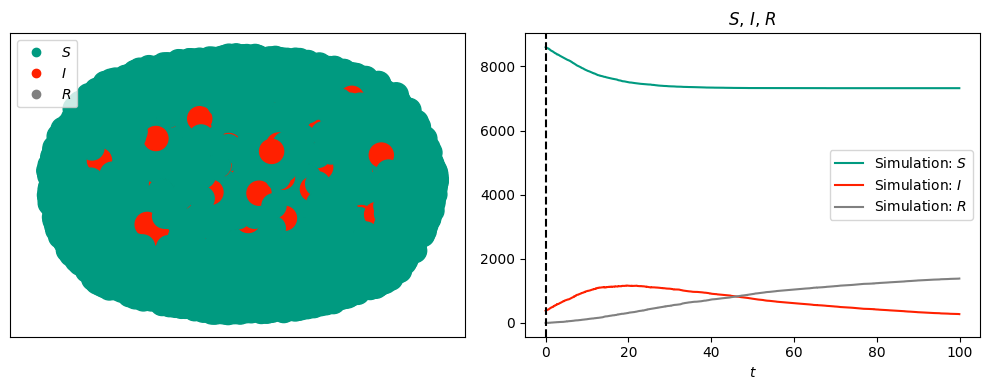

In [26]:
sim = EoN.fast_SIR(G, tau=0.05, gamma=0.02, initial_infecteds=initial_infected_nodes, tmax=100,return_full_data=True)
ani=sim.animate(ts_plots=["SIR"])
ani.save("SIR_ba-g1-b10-N2.mp4", fps=5,\
extra_args=["-vcodec", "libx264"])

## School/ Work network

In [58]:
# Read the CSV files
households = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Graph Theory/Challenge 2/households.csv')
pro_contacts_adults = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Graph Theory/Challenge 2/pro_contacts_adults.csv')
pro_contacts_children = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Graph Theory/Challenge 2/pro_contacts_children.csv')
# Change the first column's name
households.rename(columns = {"Unnamed: 0" : "household_id"}, inplace = True)

In [59]:
# Create an empty graph
G1 = nx.Graph()

# Add nodes representing schools
schools = set(pro_contacts_children['school_id'])
for school_id in schools:
    G1.add_node(f'School {school_id}', type='school')

# Add nodes representing workplaces
workplaces = set(pro_contacts_adults['company_id'])
for company_id in workplaces:
    G1.add_node(f'Workplace {company_id}', type='workplace')

# Add edges representing contacts between adults and workplaces with weights
for _, row in pro_contacts_adults.iterrows():
    household_id = row['household_id']
    company_id = row['company_id']
    pro_contacts = row['pro_contacts']
    G1.add_edge(f'Workplace {company_id}', f'Household {household_id}', weight=pro_contacts)

# Add edges representing contacts between children and schools with weights
for _, row in pro_contacts_children.iterrows():
    household_id = row['household_id']
    school_id = row['school_id']
    school_contacts = row['school_contacts']
    G1.add_edge(f'School {school_id}', f'Household {household_id}', weight=school_contacts)

In [60]:
print(G1)

Graph with 4064 nodes and 9399 edges


In [61]:
# Calculate the average degree
total_degree = sum(dict(G1.degree()).values())
average_degree = total_degree / len(G1)

# Print the average degree
print("Average degree:", average_degree)

Average degree: 4.625492125984252


In [62]:
# Define the threshold for maximum allowable contacts
threshold = 10

# Measure the number of contacts exceeding the threshold
contacts_exceeding_threshold = 0
for edge in G1.edges(data=True):
    if edge[2]['weight'] > threshold:
        contacts_exceeding_threshold += 1

print(f"Number of contacts exceeding the threshold ({threshold}): {contacts_exceeding_threshold}")

Number of contacts exceeding the threshold (10): 6600


In [63]:
# Define the epidemic parameters
infection_rate = 0.5  # Probability of infection
recovery_rate = 0.02  # Probability of recovery

# Run multiple simulations
num_simulations = 10

# List to store the results
results = []

for sim in range(num_simulations):
    # Initialize the epidemic model
    initial_infected = random.sample(list(G1.nodes()),100)

    # Set up the simulation
    t, S, I, R = EoN.fast_SIR(G1, infection_rate, recovery_rate, initial_infecteds=initial_infected , tmax=100)

    # Measure the loss in terms of deaths, infectious rate, and recovery rate
    num_deaths = R[-1] 
    infectious_rate = sum(I) / (len(G1.nodes()) * len(t))
    recovery_rate = sum(R) / (len(G1.nodes()) * len(t))

    # Store the results in a dictionary
    result = {
        'Simulation': sim + 1,
        'Deaths': num_deaths,
        'Infectious Rate': infectious_rate,
        'Recovery Rate': recovery_rate
    }
    results.append(result)

# Create a dataframe from the results
df_results = pd.DataFrame(results)

# Display the results
print(df_results)

   Simulation  Deaths  Infectious Rate  Recovery Rate
0           1    3481         0.522217       0.207642
1           2    3746         0.369679       0.282188
2           3    3483         0.336347       0.266497
3           4    3508         0.338096       0.268698
4           5    3451         0.343812       0.258827
5           6    3040         0.299231       0.230552
6           7    3661         0.364108       0.274516
7           8    3203         0.304251       0.248096
8           9    3680         0.352629       0.282593
9          10    3762         0.354068       0.291962


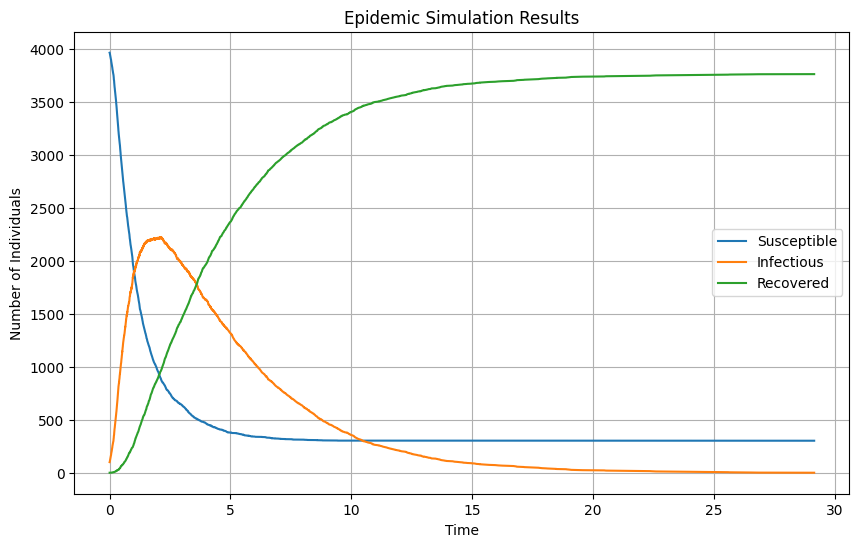

In [64]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t,S, label= "Susceptible")
plt.plot(t, I, label='Infectious')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.title('Epidemic Simulation Results')
plt.legend()
plt.grid(True)
plt.show()

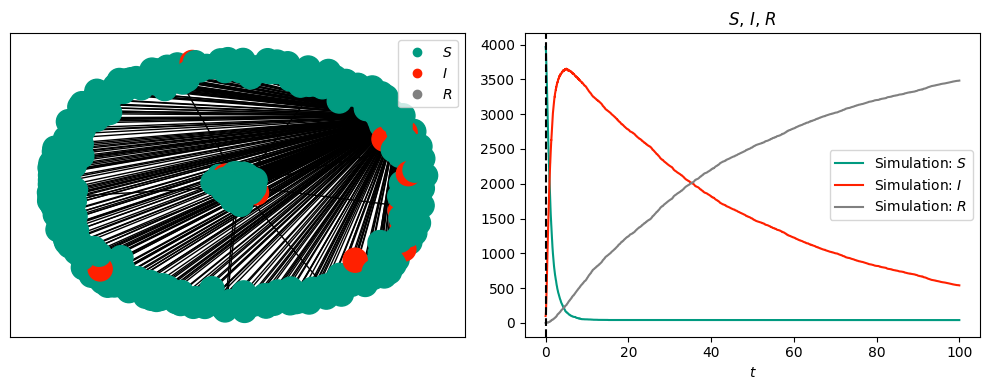

In [65]:
sim = EoN.fast_SIR(G1, tau=0.5, gamma=0.02, initial_infecteds=initial_infected, tmax=100,return_full_data=True)
ani=sim.animate(ts_plots=["SIR"])
ani.save("SIR_ba-g1-b10-N3.mp4", fps=5,\
extra_args=["-vcodec", "libx264"])

In [66]:
# Calculate the degree centrality for each node in the graph
degree_centrality = nx.degree_centrality(G1)

# Set a threshold for the degree centrality
degree_centrality_threshold = 0.05

# Identify nodes with degree centrality above the threshold
nodes_to_remove = [node for node, centrality in degree_centrality.items() if centrality > degree_centrality_threshold]

# Remove the identified nodes and their associated edges from the graph
G1.remove_nodes_from(nodes_to_remove)

# Recalculate the number of contacts exceeding the threshold after removing nodes
contacts_exceeding_threshold = 0
for edge in G1.edges(data=True):
    if edge[2]['weight'] > threshold:
        contacts_exceeding_threshold += 1

print(f"Number of contacts exceeding the threshold ({threshold}): {contacts_exceeding_threshold}")

Number of contacts exceeding the threshold (10): 3707


In [67]:
# Define the epidemic parameters
infection_rate = 0.5  # Probability of infection
recovery_rate = 0.02  # Probability of recovery

# Run multiple simulations
num_simulations = 10

# List to store the results
results = []

for sim in range(num_simulations):
    # Initialize the epidemic model
    initial_infected = random.sample(list(G1.nodes()),100)

    # Set up the simulation
    t, S, I, R = EoN.fast_SIR(G1, infection_rate, recovery_rate, initial_infecteds=initial_infected , tmax=100)

    # Measure the loss in terms of deaths, infectious rate, and recovery rate
    num_deaths = R[-1] 
    infectious_rate = sum(I) / (len(G1.nodes()) * len(t))
    recovery_rate = sum(R) / (len(G1.nodes()) * len(t))

    # Store the results in a dictionary
    result = {
        'Simulation': sim + 1,
        'Deaths': num_deaths,
        'Infectious Rate': infectious_rate,
        'Recovery Rate': recovery_rate
    }
    results.append(result)

# Create a dataframe from the results
df_results = pd.DataFrame(results)

# Display the results
print(df_results)

   Simulation  Deaths  Infectious Rate  Recovery Rate
0           1    2722         0.406705       0.166189
1           2    2769         0.265989       0.214773
2           3    2564         0.234994       0.204980
3           4    2629         0.243894       0.208549
4           5    2618         0.233533       0.212372
5           6    2738         0.258202       0.214842
6           7    2595         0.238709       0.206947
7           8    2690         0.249709       0.213167
8           9    2626         0.238433       0.210909
9          10    2560         0.242674       0.200647


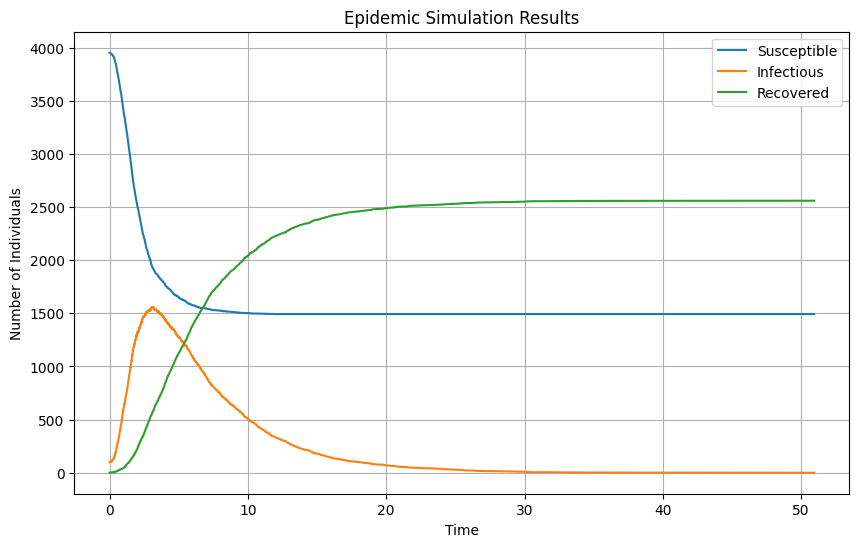

In [68]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t,S, label= "Susceptible")
plt.plot(t, I, label='Infectious')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.title('Epidemic Simulation Results')
plt.legend()
plt.grid(True)
plt.show()

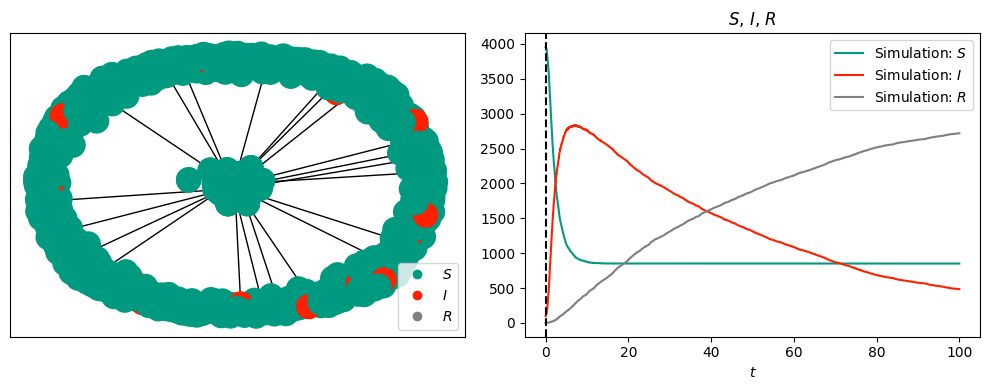

In [69]:
sim = EoN.fast_SIR(G1, tau=0.5, gamma=0.02, initial_infecteds=initial_infected, tmax=100,return_full_data=True)
ani=sim.animate(ts_plots=["SIR"])
ani.save("SIR_ba-g1-b10-N4.mp4", fps=5,\
extra_args=["-vcodec", "libx264"])

# Create graph without edgelists as input



Some ideas:

* for friendship networks: To simulate friendship, you'll have to generate edges by yourselves. No pre-defined "affiliation" is given... as friendship are real networks... and real networks of many different types share some common properties. Do you recall them? See Chapter 5 of THE book.

* for professional networks: Generate graphs with a given degree sequence or expected degree sequence to fit professional contacts, instead of using school/company affiliation


[Graph generators (implementation of several networks models) with NetworkX](https://networkx.github.io/documentation/stable/reference/generators.html)